# Benchmark of the models

In this notebook, we aim at comparing the performances of the latent gaussian mixture classifier model with other non latent classifier like RandomForest, XGBoost, or the Logistic regression.

To that end, the data will be generated according to the following model that suits the context of the latent gaussian mixture classifier:
$$
\begin{align}
&Z \sim \mathcal{B}(\pi) \\
&X | Z = k \sim \mathcal{N}(\mu_k, \Sigma_k) \\
&\mathbb{P}(Y = 1| X, Z) = \sigma(W_{e,k}^T e_k + W_{x,k}^T X)
\end{align}
$$

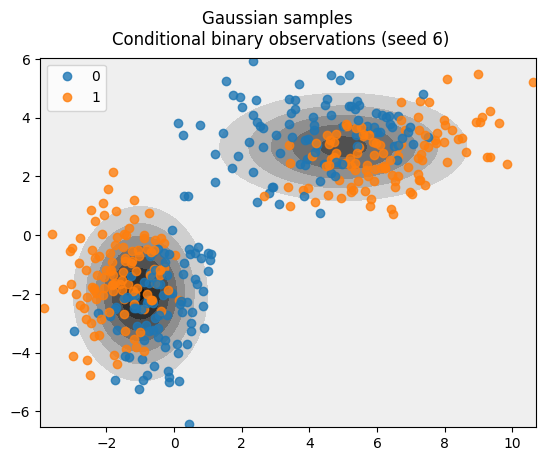

Proportion of label 1 is 0.5575


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import src.utils.viz as viz
import src.data.dataloader as dataloader

mu_list = np.array([[-1, -2], [5, 3]])
sigma_list = np.array([[1, 1.5], [2, 1]])

X, Z = dataloader.generate_gaussian(
    n_samples=200,
    d=2,
    mu_list=mu_list,
    sigma_list=sigma_list,
)

seed = 6
y, W_e, W_x = dataloader.generate_conditional_binary_observations(X, Z, seed=seed, returnParams=True)

X_train, y_train, X_test, y_test = dataloader.get_train_test(X, y, n_train=100)

viz.plot_2d_gaussians_samples_with_pdf(X, y, mu=mu_list, sigma=sigma_list, subtitle=f"Conditional binary observations (seed {seed})", alpha=0.8)
plt.show()

print(f"Proportion of label 1 is {y.sum()/len(y)}")

We define an evaluation procedure to compare the model performances on multiple folds of the data.

In [74]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

def evaluate(model, predict_fun, n_folds=5, test_size=0.5, training_steps=0):

    stratifier = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size)
    size = n_folds
    accuracies = np.zeros(size)
    balanced_accuracies = np.zeros(size)
    f1_scores = np.zeros(size)
    cm_total = 0
    for i, (train_index, test_index) in enumerate(stratifier.split(X, y)):
        print("* Fold", i)
        X_train_fold, y_train_fold = X[train_index], y[train_index]
        X_test_fold, y_test_fold = X[test_index], y[test_index]
        model.fit(X_train_fold, y_train_fold)
        if training_steps > 0:
            model.train(training_steps, 1)
        y_pred = predict_fun(X_test_fold)
        print("     Accuracy:", accuracy_score(y_test_fold, y_pred))
        print("     Balanced Accuracy:", balanced_accuracy_score(y_test_fold, y_pred))
        print("     F1 score:", f1_score(y_test_fold, y_pred))
        print("     Confusion matrix:\n", confusion_matrix(y_test_fold, y_pred))

        accuracies[i] = accuracy_score(y_test_fold, y_pred)
        balanced_accuracies[i] = balanced_accuracy_score(y_test_fold, y_pred)
        f1_scores[i] = f1_score(y_test_fold, y_pred)
        cm_total += confusion_matrix(y_test_fold, y_pred)

    print("======================================================")
    print("[Summary]")
    print("     Accuracy:", accuracies.mean(), "±", accuracies.std())
    print("     Balanced Accuracy:", balanced_accuracies.mean(), "±", balanced_accuracies.std())
    print("     F1 score:", f1_scores.mean(), "±", f1_scores.std())
    print("     (sum) Confusion matrix:\n", cm_total)
    return accuracies, balanced_accuracies, f1_scores, cm_total

def vizualize_pred(model, predict_fun, model_name, alpha=0.8, training_steps=0):
    model.fit(X_train, y_train)
    if training_steps > 0:
        model.train(training_steps, 1)
    y_pred = predict_fun(X_test)
    acc = accuracy_score(y_test, y_pred)
    if training_steps > 0:
        viz.plot_2d_gaussians_samples_with_pdf(X_test, y_pred, mu=model.mu, sigma=model.sigma, subtitle=f"Latent GMM - Accuracy {str(acc*100)[0:4]}%", alpha=alpha)
    else:
        fig, axs = plt.subplots()
        fig.suptitle(f"{model_name} predictions \nAccuracy: {str(acc*100)[0:4]}%")
        for label in np.unique(y_pred):
            sub_X = X_test[y_pred == label]
            axs.plot(sub_X[:, 0], sub_X[:, 1], label=label, marker="o", linestyle='', alpha=alpha)
        axs.legend()
    plt.show()

## Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(
    penalty="l2",
    tol=1e-10,
    random_state=1
)

logistic_reg_eval = evaluate(logistic_reg, logistic_reg.predict, n_folds=10, test_size=0.5)

* Fold 0
     Accuracy: 0.46
     Balanced Accuracy: 0.42775974025974023
     F1 score: 0.5909090909090909
     Confusion matrix:
 [[14 74]
 [34 78]]
* Fold 1
     Accuracy: 0.54
     Balanced Accuracy: 0.4864864864864865
     F1 score: 0.7012987012987013
     Confusion matrix:
 [[  0  89]
 [  3 108]]
* Fold 2
     Accuracy: 0.58
     Balanced Accuracy: 0.5336572527583764
     F1 score: 0.7162162162162163
     Confusion matrix:
 [[ 10  79]
 [  5 106]]
* Fold 3
     Accuracy: 0.44
     Balanced Accuracy: 0.409758072679421
     F1 score: 0.5757575757575757
     Confusion matrix:
 [[12 77]
 [35 76]]
* Fold 4
     Accuracy: 0.5
     Balanced Accuracy: 0.469379491851402
     F1 score: 0.6240601503759399
     Confusion matrix:
 [[17 72]
 [28 83]]
* Fold 5
     Accuracy: 0.365
     Balanced Accuracy: 0.330762987012987
     F1 score: 0.5207547169811321
     Confusion matrix:
 [[ 4 84]
 [43 69]]
* Fold 6
     Accuracy: 0.555
     Balanced Accuracy: 0.5
     F1 score: 0.7138263665594855
     Con

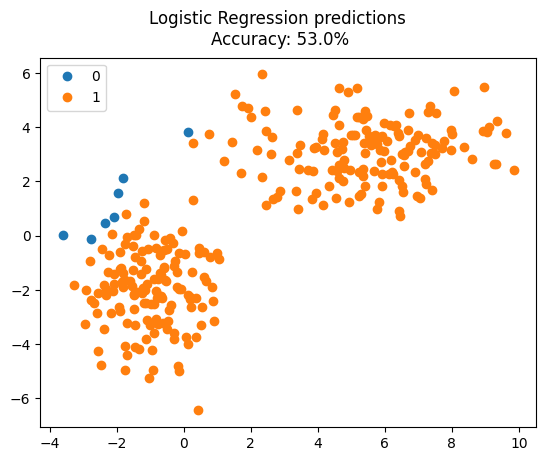

In [62]:
vizualize_pred(logistic_reg, logistic_reg.predict, "Logistic Regression")

## Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(
    n_estimators=100,
    random_state=0
)

randomforest_eval = evaluate(randomforest, randomforest.predict, n_folds=10, test_size=0.5)

* Fold 0
     Accuracy: 0.765
     Balanced Accuracy: 0.768262987012987
     F1 score: 0.7793427230046948
     Confusion matrix:
 [[70 18]
 [29 83]]
* Fold 1
     Accuracy: 0.79
     Balanced Accuracy: 0.7796266233766234
     F1 score: 0.8220338983050847
     Confusion matrix:
 [[61 27]
 [15 97]]
* Fold 2
     Accuracy: 0.75
     Balanced Accuracy: 0.7414772727272727
     F1 score: 0.7844827586206896
     Confusion matrix:
 [[59 29]
 [21 91]]
* Fold 3
     Accuracy: 0.785
     Balanced Accuracy: 0.7818098997874279
     F1 score: 0.8071748878923768
     Confusion matrix:
 [[67 22]
 [21 90]]
* Fold 4
     Accuracy: 0.785
     Balanced Accuracy: 0.7695616965279887
     F1 score: 0.8244897959183672
     Confusion matrix:
 [[ 56  33]
 [ 10 101]]
* Fold 5
     Accuracy: 0.75
     Balanced Accuracy: 0.7426948051948052
     F1 score: 0.782608695652174
     Confusion matrix:
 [[60 28]
 [22 90]]
* Fold 6
     Accuracy: 0.715
     Balanced Accuracy: 0.7114448051948052
     F1 score: 0.74439461883

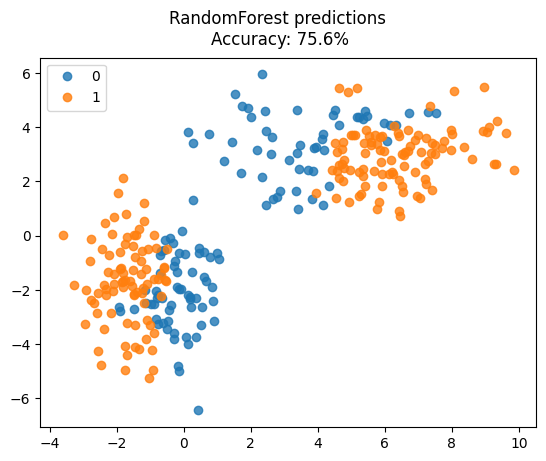

In [67]:
vizualize_pred(randomforest, randomforest.predict, "RandomForest")

## XGBoost

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

xgboost = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    random_state=0
)

xgboost_eval = evaluate(xgboost, xgboost.predict, n_folds=10, test_size=0.5)

* Fold 0
     Accuracy: 0.76
     Balanced Accuracy: 0.7570604312177346
     F1 score: 0.7837837837837838
     Confusion matrix:
 [[65 24]
 [24 87]]
* Fold 1
     Accuracy: 0.765
     Balanced Accuracy: 0.7585227272727273
     F1 score: 0.7947598253275109
     Confusion matrix:
 [[62 26]
 [21 91]]
* Fold 2
     Accuracy: 0.755
     Balanced Accuracy: 0.7625771839254986
     F1 score: 0.7586206896551725
     Confusion matrix:
 [[74 15]
 [34 77]]
* Fold 3
     Accuracy: 0.725
     Balanced Accuracy: 0.7228084415584416
     F1 score: 0.751131221719457
     Confusion matrix:
 [[62 26]
 [29 83]]
* Fold 4
     Accuracy: 0.78
     Balanced Accuracy: 0.7706245571414111
     F1 score: 0.811965811965812
     Confusion matrix:
 [[61 28]
 [16 95]]
* Fold 5
     Accuracy: 0.765
     Balanced Accuracy: 0.7646103896103896
     F1 score: 0.7853881278538813
     Confusion matrix:
 [[67 21]
 [26 86]]
* Fold 6
     Accuracy: 0.76
     Balanced Accuracy: 0.7648547423828322
     F1 score: 0.769230769230769

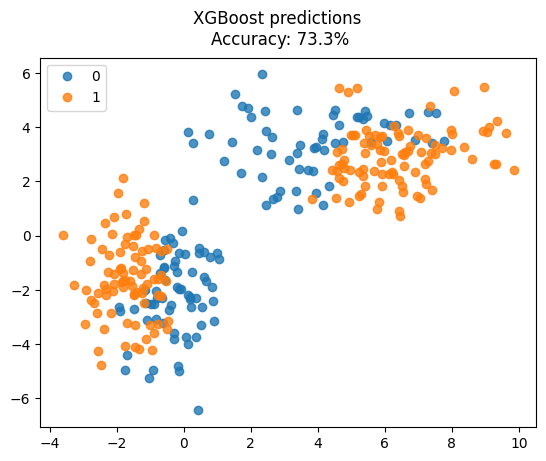

In [85]:
vizualize_pred(xgboost, xgboost.predict, "XGBoost")

## Latent Gaussian Mixture classifier

In [76]:
from src.model import GaussianMixtureClassifier
from src.utils.optimizers import GradientDescent

gmm = GaussianMixtureClassifier(
    z_dim=2,
    optimizer=GradientDescent(learning_rate=0.1, n_iter=10),
    seed=0
)
training_steps = 15

gmm_eval = evaluate(gmm, gmm.classify, n_folds=10, test_size=0.5, training_steps=training_steps)

* Fold 0
[*] EM (0/15): 
  * likelihood: -5.855487126412594
  * Q: -6.473420546591428
[*] EM (1/15): 
  * likelihood: -5.742981801559619
  * Q: -6.256397422217129
[*] EM (2/15): 
  * likelihood: -5.501695106743633
  * Q: -5.781854711720749
[*] EM (3/15): 
  * likelihood: -4.9538121230235115
  * Q: -5.005854484310847
[*] EM (4/15): 
  * likelihood: -4.655361510956238
  * Q: -4.659323552323335
[*] EM (5/15): 
  * likelihood: -4.614981872628453
  * Q: -4.617990475646194
[*] EM (6/15): 
  * likelihood: -4.592484789681599
  * Q: -4.595378128581135
[*] EM (7/15): 
  * likelihood: -4.575235776578575
  * Q: -4.577998435420976
[*] EM (8/15): 
  * likelihood: -4.561639652457017
  * Q: -4.564299683846083
[*] EM (9/15): 
  * likelihood: -4.55067978583792
  * Q: -4.553259921973229
[*] EM (10/15): 
  * likelihood: -4.54167760760655
  * Q: -4.544194380470776
[*] EM (11/15): 
  * likelihood: -4.534165249045136
  * Q: -4.536630902724377
[*] EM (12/15): 
  * likelihood: -4.527810733749742
  * Q: -4.5302

[*] EM (0/15): 
  * likelihood: -5.754052969170142
  * Q: -6.136375201152157
[*] EM (1/15): 
  * likelihood: -5.590725664725726
  * Q: -5.976827372838504
[*] EM (2/15): 
  * likelihood: -5.230502206426178
  * Q: -5.455100116169109
[*] EM (3/15): 
  * likelihood: -4.844800070994944
  * Q: -4.906167062409074
[*] EM (4/15): 
  * likelihood: -4.59529381834416
  * Q: -4.6063109900218935
[*] EM (5/15): 
  * likelihood: -4.543489239352656
  * Q: -4.5532043412265235
[*] EM (6/15): 
  * likelihood: -4.526782744041509
  * Q: -4.536532285557213
[*] EM (7/15): 
  * likelihood: -4.515807657553327
  * Q: -4.525590227270483
[*] EM (8/15): 
  * likelihood: -4.507927331260899
  * Q: -4.517728572100717
[*] EM (9/15): 
  * likelihood: -4.502045242196818
  * Q: -4.51185844814944
[*] EM (10/15): 
  * likelihood: -4.497524375346121
  * Q: -4.507346250696874
[*] EM (11/15): 
  * likelihood: -4.4939642756860065
  * Q: -4.503792803239143
[*] EM (12/15): 
  * likelihood: -4.491101994430469
  * Q: -4.50093570710

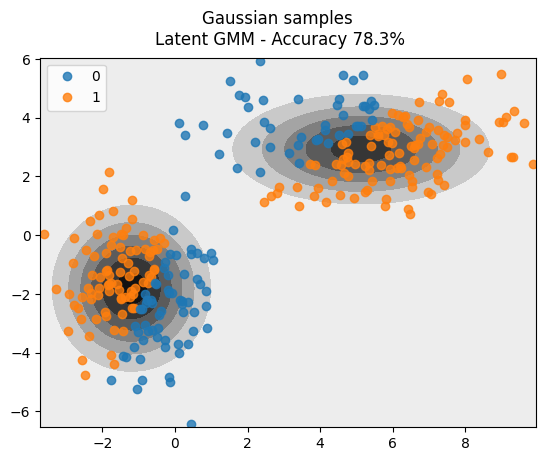

In [75]:
vizualize_pred(gmm, gmm.classify, "GMM Classifier", training_steps=training_steps)

# Benchmark conclusion

We compare each model given their respective metric within a dataframe

In [92]:
import pandas as pd

evals = [
    logistic_reg_eval,
    randomforest_eval,
    xgboost_eval,
    gmm_eval
]

benchmark = pd.DataFrame(columns=['model', 'accuracy', 'balanced_accuracy', 'f1_score'])

benchmark['model'] = ['Logistic Regression', 'RandomForest', 'XGBoost', 'GMM Linear Classifier']
benchmark['accuracy'] = [model_eval[0].mean() for model_eval in evals]
benchmark['balanced_accuracy'] = [model_eval[1].mean() for model_eval in evals]
benchmark['f1_score'] = [model_eval[2].mean() for model_eval in evals]

benchmark = benchmark.sort_values(by=['accuracy'], ascending=False)

benchmark

,model,accuracy,balanced_accuracy,f1_score
1,RandomForest,0.772,0.765851,0.799993
3,GMM Linear Classifier,0.772,0.763116,0.804060
2,XGBoost,0.766,0.763753,0.787602
0,Logistic Regression,0.519,0.477064,0.658736
